<h1 style="text-align:center;">Лабораторная работа №4</h2>

<h2 style="text-align:center;">Решение нелинейного дифференциального уравнения с краевым условием</h2>

<h3 style="text-align:center;">Тулупов Николай Дмитриевич</h3>
<h3 style="text-align:center;">Б01-204</h3>

### **Введение**

Цель: решить нелинейное краевое ДУ 2 порядка методом стрельбы И методом квазилинеаризации Ньютона (проверить сходимость решения по расчетной сетке).

<img src="task.png" alt="drawing" width="500"/>

Здесь $p$ - параметр, управляющий степенью нелинейности.

In [188]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt

### **Метод стрельбы**

Суть метода — заменить краевую задачу на начальную и подбирать начальное значение так, чтобы удовлетворялись условия на другом конце отрезка.
Уравнение нелинейное, но нежесткое почти при всех p, поэтому вполне адекватным будет использование явного метода РК4 из лабы 1.

In [189]:
def f(t, Y, p):
    y1, y2 = Y
    dy1 = y2
    dy2 = -p * t * math.cos(y1)
    return [dy1, dy2]

In [190]:
def runge_kutt_explicit(f, t, Y, h, order):
    l = len(Y)
    if order == 1:
        k1 = f(t, Y)
        return [ (Y[i] + h * k1[i])  for i in range(l)]
    
    elif order == 2:
        k1 = f(t, Y)
        Y_pred = [Y[i] + h * k1[i] for i in range(l)]  # прогноз
        k2 = f(t + h, Y_pred)
        return [Y[i] + h * (k1[i] + k2[i]) / 2 for i in range(l)]
    
    elif order == 3:
        k1 = f(t, Y)
        Y_pred_12 = [Y[i] + h * k1[i] / 2 for i in range(l)]
        k2 = f(t + h/2, Y_pred_12)
        Y_pred_23 =  [Y[i] - h * k1[i] + 2 * h * k2[i] for i in range(l)]
        k3 = f(t + h, Y_pred_23)
        return [Y[i] + h * (k1[i] + 4*k2[i] + k3[i]) / 6 for i in range(l)]
    
    elif order == 4:
        k1 = f(t, Y)
        Y_pred_12 = [Y[i] + h * k1[i] / 2 for i in range(l)]
        k2 = f(t + h / 2, Y_pred_12)
        Y_pred_23 = [Y[i] + h * k2[i] / 2 for i in range(l)]
        k3 = f(t + h / 2, Y_pred_23)
        Y_pred_34 = [Y[i] + h * k3[i] for i in range(l)]
        k4 = f(t + h, Y_pred_34)
        return [Y[i] + h * (k1[i] + 2*k2[i] + 2*k3[i] + k4[i]) / 6 for i in range(l)]
    
    else:
        print("ERROR! Порядок должен быть от 1 до 4")
        return 

In [191]:
def integrate_runge_kutt_explicit(f, Y0, t_start, t_stop, h, order):
    t = t_start
    Y = Y0[:]
    S = [[t] + Y] 

    while t < t_stop:
        Y = runge_kutt_explicit(f, t, Y, h, order)
        t += h
        S.append([t] + Y)

    return S #траектория

Функция integrate_runge_kutt_explicit(f, Y0, t_start, t_stop, h, order) не нужна - она возвращает целую траекторию, а нам нужно лишь конечное значение.

In [192]:
def solve_shooting(a0, p, h=0.01, order=4):
    f_wrapped = lambda t, Y: f(t, Y, p)
    Y0 = [a0, 0]
    S = integrate_runge_kutt_explicit(f_wrapped, Y0, 0, 1, h, order)
    return S[-1][1]  # это y(1) — значение в конце, сравниваем с нулём


Подбор $а0$ произведем через метод секущих:
$$a_{new} = a_2 - (a_2-a_1) * y_2 / (y_2-y_1)  $$
То есть проводим прямую через точки $(a1, y1)$ и $(a2, y2)$ и ищем ее пересечение с осью $y=0$.   
Если новое $y(1)$ достаточно близко к нулю — решение найдено. Если нет - продвигаемся по ходу вычислений — берём последние две точки и повторяем.

In [193]:
def shooting_method_secant(p, a1, a2, tol=1e-6, max_iter=1000):
    y1 = solve_shooting(a1, p)
    y2 = solve_shooting(a2, p)
    
    for _ in range(max_iter):
        if abs(y2 - y1) < 1e-12: break  # защита от деления на 0
        a_new = a2 - y2 * (a2 - a1) / (y2 - y1)
        y_new = solve_shooting(a_new, p)
        if abs(y_new) < tol:
            return a_new
        a1, y1 = a2, y2
        a2, y2 = a_new, y_new
    print("Метод секущих не сошелся за max_iter!")
    return a2  # если не сошлось, возвращаем последнее значение


In [194]:
p = 100
a_values = np.linspace(0, 3, 100)
y1_values = [solve_shooting(a, p) for a in a_values]

a0_found = shooting_method_secant(p, 0.1, 1.5)
print("Подобранное y(0):", a0_found)

Подобранное y(0): 1.5641073095346256


In [195]:
p = 100
a_values = np.linspace(0, 3, 100)
y1_values = [solve_shooting(a, p) for a in a_values]

a0_found = shooting_method_secant(p, a_values[0], a_values[-1])
print("Подобранное y(0):", a0_found)

Подобранное y(0): -4.438175413023454


Как видим, если взять достаточно широкий диапазон, на котором при больших p функция имеет несколько корней или даже осциллирует, метод секущих может уйти к "не тому корню" или вообще в сторону ложного корня.   
В случае небольшого диапазона - там функция почти линейна, только один корень, и метод секущих его уверенно находит.   

В связи с этим перепишем фукнцию стрельбы методом бисекции - постоянного деления на 2. Этот метод будет искать корень медленнее и требует, чтобы на концах интервала были разные знаки. Зато его использование гарантирует, что найденный корень будет лежать в интервале.

In [196]:
def shooting_method_bisection(p, a1, a2, tol=1e-6, max_iter=1000):
    y1 = solve_shooting(a1, p)
    y2 = solve_shooting(a2, p)

    if y1 * y2 > 0:
        print("На концах отрезка одинаковые знаки — метод бисекции не применим!")
        return None

    for _ in range(max_iter):
        a_mid = (a1 + a2) / 2
        y_mid = solve_shooting(a_mid, p)

        if abs(y_mid) < tol:
            return a_mid

        if y1 * y_mid < 0:
            a2, y2 = a_mid, y_mid
        else:
            a1, y1 = a_mid, y_mid

        if abs(a2 - a1) < tol:
            return (a1 + a2) / 2

    print("Бисекция не сошлась за max_iter")
    return (a1 + a2) / 2


In [197]:
p = 100
a_values = np.linspace(0, 3, 100)
y1_values = [solve_shooting(a, p) for a in a_values]

a0_found = shooting_method_bisection(p, 0.1, 1.5)
print("Подобранное y(0):", a0_found)

На концах отрезка одинаковые знаки — метод бисекции не применим!
Подобранное y(0): None


In [198]:
p = 100
a_values = np.linspace(0, 3, 100)
y1_values = [solve_shooting(a, p) for a in a_values]

a0_found = shooting_method_bisection(p, a_values[0], a_values[-1])
print("Подобранное y(0):", a0_found)

Подобранное y(0): 1.5641072988510132


Подобранное y(0): 1.5641072518897783


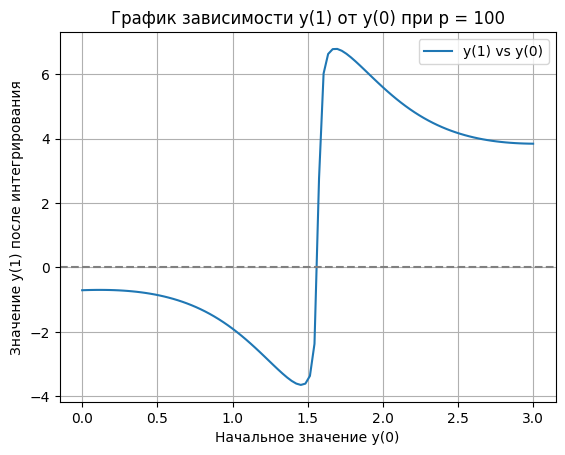

In [199]:
p = 100
a_values = np.linspace(0, 3, 100)
y1_values = [solve_shooting(a, p) for a in a_values]

a0_found = shooting_method_bisection(p, a_values[1], a_values[-1])
print("Подобранное y(0):", a0_found)

plt.plot(a_values, y1_values, label='y(1) vs y(0)')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Начальное значение y(0)')
plt.ylabel('Значение y(1) после интегрирования')
plt.title(f'График зависимости y(1) от y(0) при p = {p}')
plt.grid(True)
plt.legend()
plt.show()

Подобранное y(0): -4.438175467812256


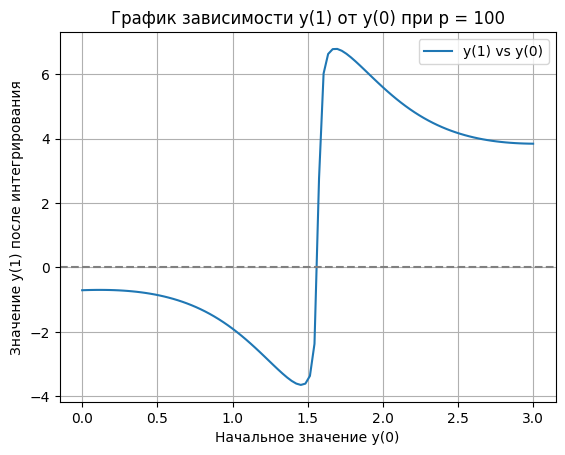

In [200]:
p = 100
a_values = np.linspace(0, 3, 100)
y1_values = [solve_shooting(a, p) for a in a_values]

a0_found = shooting_method_secant(p, a_values[1], a_values[-1])
print("Подобранное y(0):", a0_found)

plt.plot(a_values, y1_values, label='y(1) vs y(0)')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Начальное значение y(0)')
plt.ylabel('Значение y(1) после интегрирования')
plt.title(f'График зависимости y(1) от y(0) при p = {p}')
plt.grid(True)
plt.legend()
plt.show()

In [201]:
def drawing():
    p_vals = [1, 4, 7, 25, 50, 100]
    
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))  # 2 строки, 3 столбца
    axs = axs.flatten()  # чтобы обращаться как axs[0], axs[1], ...

    for i in range(len(p_vals)):
        p = p_vals[i]
        a_values = np.linspace(0, 3, 100)
        y1_values = [solve_shooting(a, p) for a in a_values]

        a0_found = shooting_method_bisection(p, a_values[1], a_values[-1])

        axs[i].plot(a_values, y1_values)
        axs[i].axhline(0, color='gray', linestyle='--')
        axs[i].set_title(f"p = {p}, найденное y(0) ≈ {a0_found:.4f}")
        axs[i].set_xlabel('y(0)')
        axs[i].set_ylabel('y(1)') 
        axs[i].grid(True)


    fig.suptitle(f"Траектория движения спутника", fontsize=16)
    plt.tight_layout()
    plt.show()

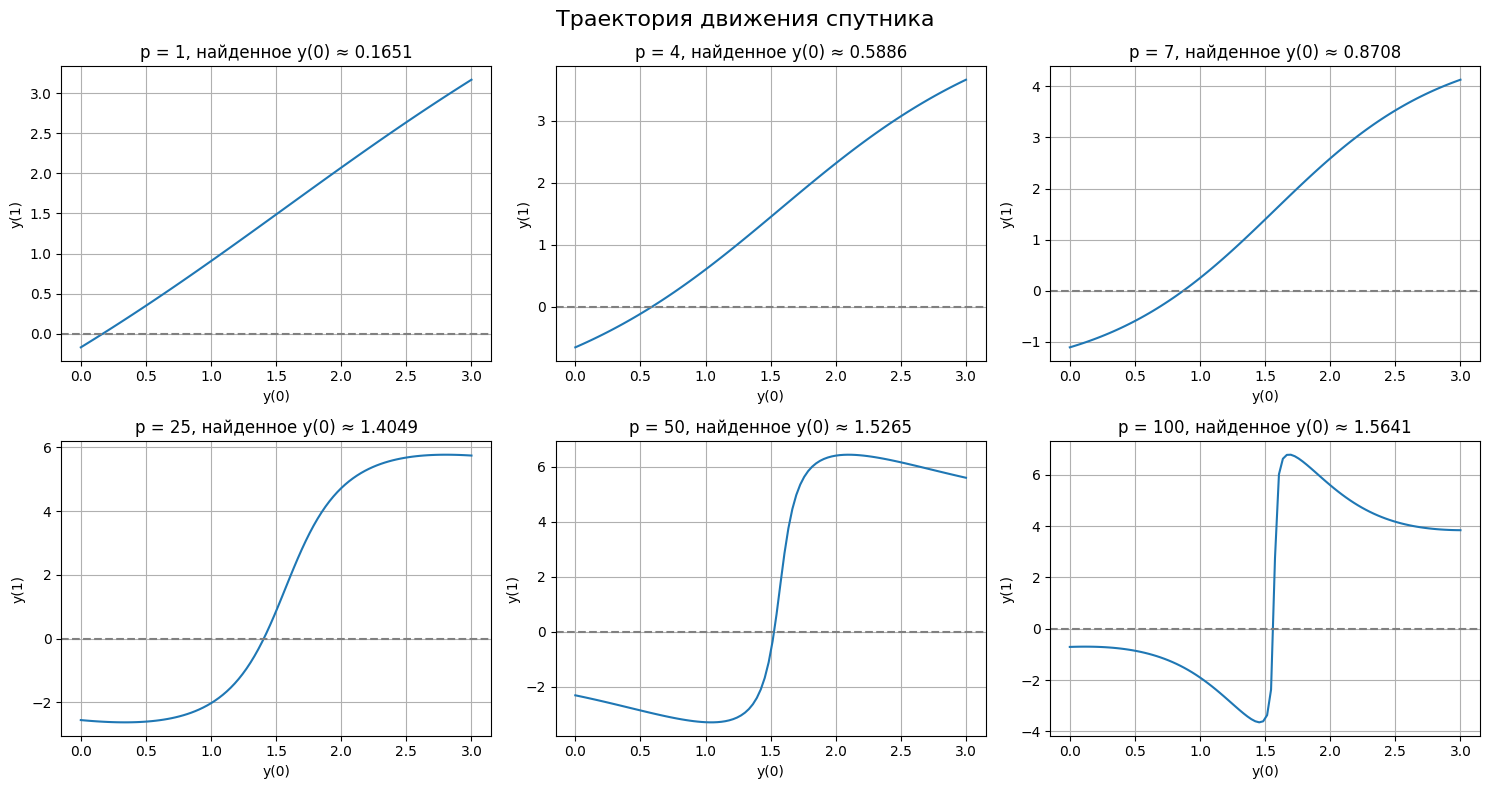

In [202]:
drawing()

 Выводы из графиков:    
- Когда $p$ маленькое (1, 4, 7):    
  Слагаемое $𝑦pxcosy$ ещё слабо влияет и поведение $y(x)$ почти линейное. Зависимость $y(1)$ от $y(0)$ — почти прямая линия.   
  Это говорит о почти линейном отклике: маленькое изменение в начале → маленькое изменение в конце

- Когда $p$ большое (25, 50, 100):    
 $𝑦pxcosy$ становится сильное нелинейным, при больших $y$ $cos(y)$ осциллирует. Уравнение начинает резонировать, и траектории становятся непредсказуемыми 
 Это признак жёсткой нелинейной системы. Поведение становится нестабильным и даже хаотичным на графике зависимости y(1) от y(0).


### **Метод квазилинеаризации Ньютона**

Это способ решения нелинейных краевых задач, в котором:
- нелинейное уравнение приводится к последовательности линейных
- на каждом шаге решаем линейную краевую задачу, приближаясь к настоящему решению